In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 12)

import sys
sys.path.insert(0, '../')

from dataloader.cityscapes import CityScapesDataset
from models.discriminator import SPADEDiscriminator, custom_model1, custom_model2
from models.spade import SPADE
from models.spade_resblk import SPADEResBlk
from models.generator import SPADEGenerator
from models.ganloss import GANLoss

## Step1: Get Data

In [2]:
path = '/home/kushaj/Desktop/Data/City Scape Dataset'
dataset = {
    x: CityScapesDataset(path, split=x, is_transform=True) for x in ['train', 'val']
}

data = {
    x: torch.utils.data.DataLoader(dataset[x], 
                  batch_size=4, 
                  shuffle=True, 
                  num_workers=4,
                  drop_last=True) for x in ['train', 'val']
}

Found 2975 train images
Found 500 val images


In [3]:
# Print images to see data is loading properly
iterator = iter(data['train'])
img, seg = next(iterator)
print(img.size())
print(seg.size())

torch.Size([4, 3, 64, 64])
torch.Size([4, 1, 64, 64])


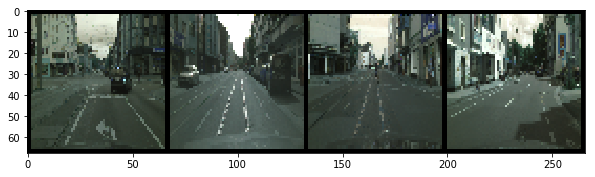

In [4]:
plt.rcParams['figure.figsize'] = (10, 6)
# Plotting functions for true image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.pause(0.001)
    
grid_img = torchvision.utils.make_grid(img, nrow=4)
imshow(grid_img)

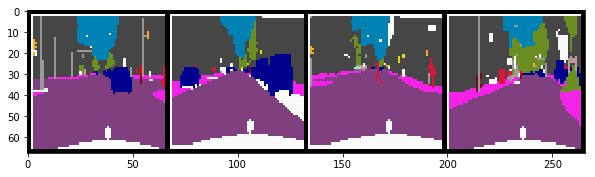

In [5]:
segmap = torch.zeros(seg.size(0), 3, seg.size(2), seg.size(3))
# Plotting function for segmentation task
for i, a in enumerate(seg):
    image = a.squeeze()
    image = image.numpy()
    image = dataset['train'].decode_segmap(image)
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image)
    segmap[i] = image
    
def imshow_seg(image):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.pause(0.001)
    
grid_img = torchvision.utils.make_grid(segmap, nrow=4)
imshow_seg(grid_img)

## Step2: Create models

In [6]:
# Create class to resemble argparse
class Args:
    def __init__(self, spade_filter=128, spade_kernel=3, spade_resblk_kernel=3, gen_input_size=256, gen_hidden_size=16384):
        self.spade_filter = spade_filter
        self.spade_kernel = spade_kernel
        self.spade_resblk_kernel = spade_resblk_kernel
        self.gen_input_size = gen_input_size
        self.gen_hidden_size = gen_hidden_size
        
        if gen_hidden_size%16 != 0:
            print("Gen hidden size not multiple of 16")

spade_filter = 64
gen_input_size = 256
gen_hidden_size = 128 * 16
args = Args(spade_filter, 3, 3, gen_input_size, gen_hidden_size)

In [7]:
class Generator(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.linear = nn.Linear(args.gen_input_size, args.gen_hidden_size)
        self.spade_resblk1 = SPADEResBlk(args, 128)
        self.spade_resblk2 = SPADEResBlk(args, 128)
        self.spade_resblk3 = SPADEResBlk(args, 64, skip=True)
        self.spade_resblk4 = SPADEResBlk(args, 32, skip=True)
        self.conv = nn.utils.spectral_norm(nn.Conv2d(32, 3, kernel_size=(3,3), padding=1))
    
    def forward(self, x, seg):
        x = self.linear(x)
        x = x.view(seg.size(0), -1, 4, 4)
        
        x = self.spade_resblk1(x, seg)
        x = F.interpolate(x, size=(2*4, 2*4), mode='nearest')
        
        x = self.spade_resblk2(x, seg)
        x = F.interpolate(x, size=(4*4, 4*4), mode='nearest')
        
        x = self.spade_resblk3(x, seg)
        x = F.interpolate(x, size=(8*4, 8*4), mode='nearest')
        
        x = self.spade_resblk4(x, seg)
        x = F.interpolate(x, size=(16*4, 16*4), mode='nearest')

        x = F.tanh(self.conv(x))
        
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = custom_model1(4, 32)
        self.layer2 = custom_model2(32, 64)
        self.layer3 = custom_model2(64, 128)
        self.layer4 = custom_model2(128, 256)
        self.inst_norm = nn.InstanceNorm2d(256)
        self.conv = nn.utils.spectral_norm(nn.Conv2d(256, 1, kernel_size=(4,4)))

    def forward(self, img, seg):
        x = torch.cat((img, seg), dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.leaky_relu(self.inst_norm(x))

        x = self.conv(x)
        return x.squeeze()

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
epochs = 100
lr_gen = 0.0001
lr_dis = 0.0004
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    raise Exception('GPU not available')
torch.backends.cudnn.benchmark = True

gen = Generator(args)
dis = Discriminator()

gen = gen.to(device)
dis = dis.to(device)

noise = torch.rand(4, 256)
noise = noise.to(device)
img = img.to(device)
seg = seg.to(device)

criterion = GANLoss()

gen.apply(weights_init)
dis.apply(weights_init)

optim_gen = torch.optim.Adam(gen.parameters(), lr=lr_gen, betas=(0, 0.999))
optim_dis = torch.optim.Adam(dis.parameters(), lr=lr_dis, betas=(0, 0.999))

In [11]:
img_lists = []
G_losses = []
D_losses = []
iters = 0

for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch+1}/{epochs}')
    for i, (img, seg) in enumerate(data['train']):
        img = img.to(device)
        seg = seg.to(device)
        
        fake_img = gen(noise, seg)
        
        # Fake Detection and Loss
        pred_fake = dis(fake_img, seg)
        loss_D_fake = criterion(pred_fake, False)
        
        # Real Detection and Loss
        pred_real = dis(img, seg)
        loss_D_real = criterion(pred_real, True)
        
        loss_G = criterion(pred_fake, True)
        loss_D = loss_D_fake + loss_D_real*0.5
        
        # Backprop
        optim_gen.zero_grad()
        loss_G.backward(retain_graph=True)
        optim_gen.step()
        
        optim_dis.zero_grad()
        loss_D.backward()
        optim_dis.step()
        
        G_losses.append(loss_G.detach().cpu())
        D_losses.append(loss_D.detach().cpu())
        
        if i%200 == 0:
            print("Iteration {}/{} started".format(i+1, len(data['train'])))
        
    print()
    if epoch%20 == 0:
        with torch.no_grad():
            img_lists.append(fake_img.detach().cpu().numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


  1%|          | 1/100 [01:51<3:03:29, 111.20s/it]


Epoch 2/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


  2%|▏         | 2/100 [03:44<3:02:50, 111.94s/it]


Epoch 3/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


  3%|▎         | 3/100 [05:39<3:02:08, 112.67s/it]


Epoch 4/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


  4%|▍         | 4/100 [07:42<3:05:22, 115.86s/it]


Epoch 5/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


  5%|▌         | 5/100 [09:44<3:06:30, 117.79s/it]


Epoch 6/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


  6%|▌         | 6/100 [11:48<3:07:22, 119.60s/it]


Epoch 7/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


  7%|▋         | 7/100 [13:51<3:07:06, 120.71s/it]


Epoch 8/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


  8%|▊         | 8/100 [15:55<3:06:33, 121.67s/it]


Epoch 9/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


  9%|▉         | 9/100 [18:00<3:05:43, 122.46s/it]


Epoch 10/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 10%|█         | 10/100 [20:04<3:04:37, 123.09s/it]


Epoch 11/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 11%|█         | 11/100 [22:08<3:03:04, 123.42s/it]


Epoch 12/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 12%|█▏        | 12/100 [24:13<3:01:32, 123.78s/it]


Epoch 13/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 13%|█▎        | 13/100 [26:17<2:59:28, 123.77s/it]


Epoch 14/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 14%|█▍        | 14/100 [28:18<2:56:22, 123.05s/it]


Epoch 15/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 15%|█▌        | 15/100 [30:25<2:56:00, 124.24s/it]


Epoch 16/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 16%|█▌        | 16/100 [32:22<2:50:53, 122.07s/it]


Epoch 17/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 17%|█▋        | 17/100 [34:19<2:46:48, 120.58s/it]


Epoch 18/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 18%|█▊        | 18/100 [36:23<2:46:12, 121.62s/it]


Epoch 19/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 19%|█▉        | 19/100 [38:27<2:45:13, 122.39s/it]


Epoch 20/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 20%|██        | 20/100 [40:30<2:43:13, 122.41s/it]


Epoch 21/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 21%|██        | 21/100 [42:32<2:41:10, 122.41s/it]


Epoch 22/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 22%|██▏       | 22/100 [44:46<2:43:20, 125.65s/it]


Epoch 23/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 23%|██▎       | 23/100 [46:52<2:41:28, 125.82s/it]


Epoch 24/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 24%|██▍       | 24/100 [48:56<2:38:41, 125.28s/it]


Epoch 25/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 25%|██▌       | 25/100 [51:01<2:36:31, 125.21s/it]


Epoch 26/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 26%|██▌       | 26/100 [53:07<2:34:42, 125.44s/it]


Epoch 27/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 27%|██▋       | 27/100 [55:09<2:31:32, 124.56s/it]


Epoch 28/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 28%|██▊       | 28/100 [57:15<2:29:48, 124.84s/it]


Epoch 29/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 29%|██▉       | 29/100 [59:18<2:27:16, 124.46s/it]


Epoch 30/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 30%|███       | 30/100 [1:01:23<2:25:05, 124.37s/it]


Epoch 31/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 31%|███       | 31/100 [1:03:27<2:23:10, 124.50s/it]


Epoch 32/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 32%|███▏      | 32/100 [1:05:30<2:20:23, 123.87s/it]


Epoch 33/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 33%|███▎      | 33/100 [1:07:36<2:18:56, 124.43s/it]


Epoch 34/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 34%|███▍      | 34/100 [1:09:37<2:15:52, 123.53s/it]


Epoch 35/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 35%|███▌      | 35/100 [1:11:36<2:12:31, 122.32s/it]


Epoch 36/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 36%|███▌      | 36/100 [1:13:41<2:11:04, 122.88s/it]


Epoch 37/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 37%|███▋      | 37/100 [1:15:45<2:09:20, 123.18s/it]


Epoch 38/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 38%|███▊      | 38/100 [1:17:50<2:08:08, 124.01s/it]


Epoch 39/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 39%|███▉      | 39/100 [1:19:50<2:04:46, 122.74s/it]


Epoch 40/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 40%|████      | 40/100 [1:21:57<2:03:52, 123.88s/it]


Epoch 41/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 41%|████      | 41/100 [1:24:00<2:01:44, 123.81s/it]


Epoch 42/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 42%|████▏     | 42/100 [1:26:05<1:59:58, 124.11s/it]


Epoch 43/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 43%|████▎     | 43/100 [1:28:14<1:59:19, 125.61s/it]


Epoch 44/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 44%|████▍     | 44/100 [1:30:26<1:58:56, 127.44s/it]


Epoch 45/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 45%|████▌     | 45/100 [1:32:29<1:55:42, 126.22s/it]


Epoch 46/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 46%|████▌     | 46/100 [1:34:27<1:51:21, 123.74s/it]


Epoch 47/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 47%|████▋     | 47/100 [1:36:26<1:47:57, 122.23s/it]


Epoch 48/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 48%|████▊     | 48/100 [1:38:24<1:44:54, 121.06s/it]


Epoch 49/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 49%|████▉     | 49/100 [1:40:20<1:41:35, 119.52s/it]


Epoch 50/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 50%|█████     | 50/100 [1:42:17<1:38:50, 118.60s/it]


Epoch 51/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 51%|█████     | 51/100 [1:44:14<1:36:24, 118.06s/it]


Epoch 52/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 52%|█████▏    | 52/100 [1:46:11<1:34:12, 117.76s/it]


Epoch 53/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 53%|█████▎    | 53/100 [1:48:11<1:32:58, 118.68s/it]


Epoch 54/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 54%|█████▍    | 54/100 [1:50:21<1:33:30, 121.96s/it]


Epoch 55/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 55%|█████▌    | 55/100 [1:52:25<1:31:55, 122.57s/it]


Epoch 56/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 56%|█████▌    | 56/100 [1:54:27<1:29:50, 122.52s/it]


Epoch 57/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 57%|█████▋    | 57/100 [1:58:07<1:48:43, 151.71s/it]


Epoch 58/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 58%|█████▊    | 58/100 [2:01:55<2:02:09, 174.52s/it]


Epoch 59/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 59%|█████▉    | 59/100 [2:05:13<2:04:05, 181.59s/it]


Epoch 60/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 60%|██████    | 60/100 [2:07:10<1:48:06, 162.16s/it]


Epoch 61/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 61%|██████    | 61/100 [2:09:07<1:36:35, 148.60s/it]


Epoch 62/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 62%|██████▏   | 62/100 [2:11:05<1:28:22, 139.54s/it]


Epoch 63/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 63%|██████▎   | 63/100 [2:13:03<1:21:57, 132.92s/it]


Epoch 64/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 64%|██████▍   | 64/100 [2:15:01<1:17:02, 128.39s/it]


Epoch 65/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 65%|██████▌   | 65/100 [2:16:59<1:13:04, 125.28s/it]


Epoch 66/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 66%|██████▌   | 66/100 [2:18:57<1:09:48, 123.18s/it]


Epoch 67/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 67%|██████▋   | 67/100 [2:20:55<1:06:50, 121.53s/it]


Epoch 68/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 68%|██████▊   | 68/100 [2:22:55<1:04:33, 121.04s/it]


Epoch 69/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 69%|██████▉   | 69/100 [2:24:53<1:02:07, 120.25s/it]


Epoch 70/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 70%|███████   | 70/100 [2:26:50<59:34, 119.16s/it]  


Epoch 71/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 71%|███████   | 71/100 [2:28:46<57:14, 118.44s/it]


Epoch 72/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 72%|███████▏  | 72/100 [2:30:43<55:03, 117.98s/it]


Epoch 73/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 73%|███████▎  | 73/100 [2:32:40<52:59, 117.78s/it]


Epoch 74/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 74%|███████▍  | 74/100 [2:34:37<50:55, 117.52s/it]


Epoch 75/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 75%|███████▌  | 75/100 [2:36:35<49:01, 117.64s/it]


Epoch 76/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 76%|███████▌  | 76/100 [2:38:32<46:58, 117.42s/it]


Epoch 77/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 77%|███████▋  | 77/100 [2:40:30<45:03, 117.54s/it]


Epoch 78/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 78%|███████▊  | 78/100 [2:42:27<43:01, 117.35s/it]


Epoch 79/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 79%|███████▉  | 79/100 [2:44:25<41:05, 117.41s/it]


Epoch 80/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 80%|████████  | 80/100 [2:46:22<39:06, 117.30s/it]


Epoch 81/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 81%|████████  | 81/100 [2:48:18<37:06, 117.17s/it]


Epoch 82/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 82%|████████▏ | 82/100 [2:50:16<35:12, 117.36s/it]


Epoch 83/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 83%|████████▎ | 83/100 [2:52:14<33:17, 117.51s/it]


Epoch 84/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 84%|████████▍ | 84/100 [2:54:12<31:21, 117.59s/it]


Epoch 85/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 85%|████████▌ | 85/100 [2:56:09<29:23, 117.56s/it]


Epoch 86/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 86%|████████▌ | 86/100 [2:58:08<27:30, 117.87s/it]


Epoch 87/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 87%|████████▋ | 87/100 [3:00:05<25:29, 117.66s/it]


Epoch 88/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 88%|████████▊ | 88/100 [3:02:04<23:35, 117.96s/it]


Epoch 89/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 89%|████████▉ | 89/100 [3:04:02<21:38, 118.04s/it]


Epoch 90/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 90%|█████████ | 90/100 [3:06:00<19:39, 117.98s/it]


Epoch 91/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 91%|█████████ | 91/100 [3:07:56<17:37, 117.50s/it]


Epoch 92/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 92%|█████████▏| 92/100 [3:09:53<15:37, 117.22s/it]


Epoch 93/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 93%|█████████▎| 93/100 [3:11:50<13:40, 117.26s/it]


Epoch 94/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 94%|█████████▍| 94/100 [3:13:48<11:44, 117.50s/it]


Epoch 95/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 95%|█████████▌| 95/100 [3:15:45<09:45, 117.20s/it]


Epoch 96/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 96%|█████████▌| 96/100 [3:17:41<07:47, 116.87s/it]


Epoch 97/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 97%|█████████▋| 97/100 [3:19:38<05:50, 116.90s/it]


Epoch 98/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 98%|█████████▊| 98/100 [3:21:35<03:54, 117.10s/it]


Epoch 99/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


 99%|█████████▉| 99/100 [3:23:33<01:57, 117.21s/it]


Epoch 100/100
Iteration 1/743 started
Iteration 201/743 started
Iteration 401/743 started
Iteration 601/743 started


100%|██████████| 100/100 [3:25:29<00:00, 116.82s/it]

In [12]:
torch.save(gen, 'gen.pth')

In [13]:
torch.save(dis, 'dis.pth')

In [29]:
g_losses = [x.item() for x in G_losses]
d_losses = [x.item() for x in D_losses]

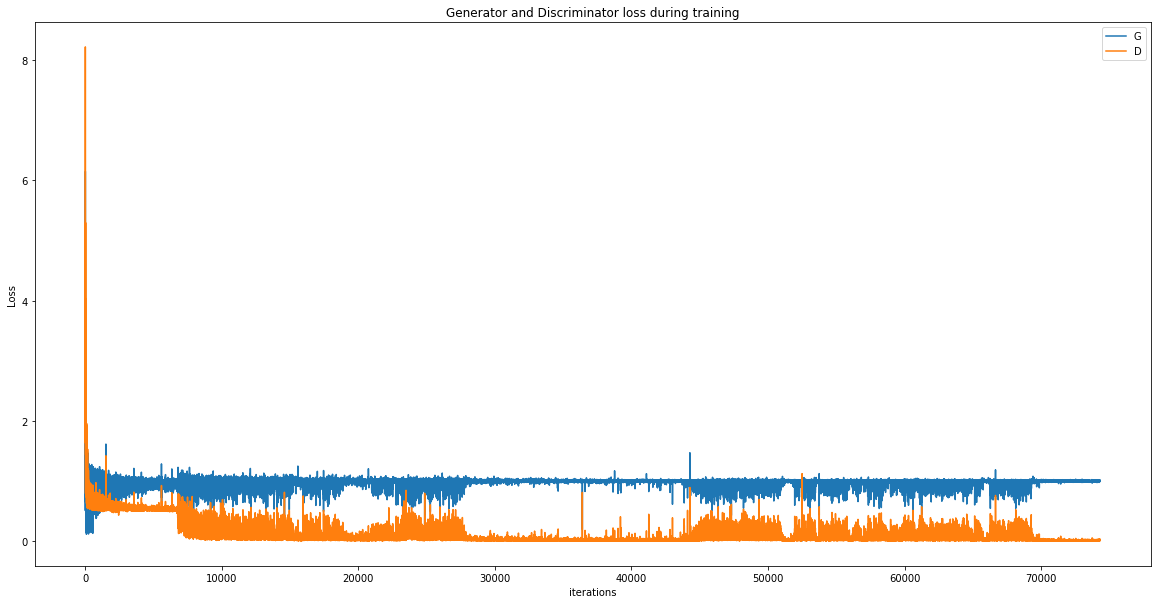

In [33]:
plt.figure(figsize=(20,10))
plt.title('Generator and Discriminator loss during training')
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
temp = np.zeros((20, 3, 64, 64))
j = 0
for i in range(5):
    a = img_lists[i]
    temp[j:j+4] = a
    j += 4 

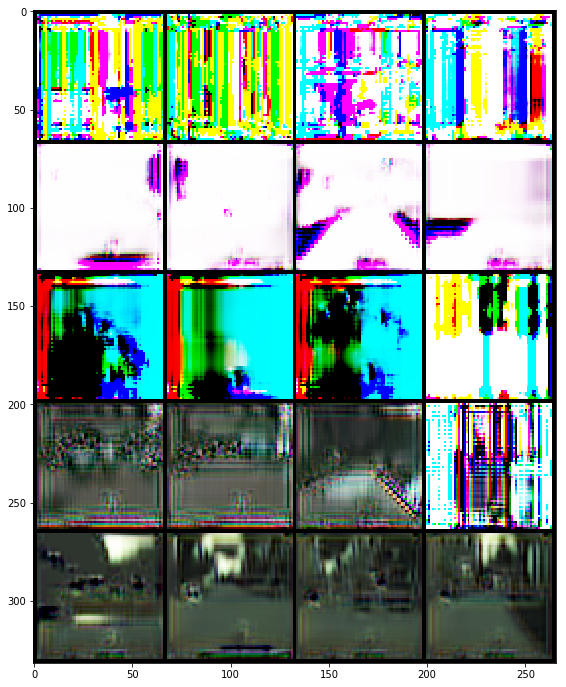

In [57]:
temp = torch.from_numpy(temp)
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.pause(0.001)
    plt.savefig('results')
    
grid_img = torchvision.utils.make_grid(temp, nrow=4)
imshow(grid_img)